Sample code for calculating the Cross Entropies between HR and Temp for the first two subjects

In [5]:
import pandas as pd
import numpy as np
import matplotlib as plt
import pickle
import EntropyHub as EH
import gc 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dropped_subjects = []

first_subject_id = 1
last_subject_id = 16 # We have 16 subjects in total, here just as an example I have only imported data from the first two subjects 


data_folder = 'new_data' # Change this to the folder in your PC with the saved data
folder_to_save = 'ACCBVP_PC' # Folder to save computed entropies


In [7]:
fs = {} # Dictionary to store sampling frequency of each signal
fs["acc"] = 32
fs["bvp"] = 64
fs["eda"] = 4
fs["temp"] = 4
fs["hr"]  = 1

epoch_seconds = 5 * 60 # 1 epoch is 5 minutes => 5min * 60 seconds/min = 300 seconds 

epoch_size = 300

In [8]:
segmented_dfs = {}
for subject_id in [id for id in range(first_subject_id, last_subject_id + 1) if id not in dropped_subjects]:
    segmented_dfs[subject_id] = pd.read_pickle(f'{data_folder}/segmented_df_{subject_id}_5MIN.pkl') 
    print(f'Loaded segmented df for subject {subject_id}.')

Loaded segmented df for subject 1.
Loaded segmented df for subject 2.
Loaded segmented df for subject 3.
Loaded segmented df for subject 4.
Loaded segmented df for subject 5.
Loaded segmented df for subject 6.
Loaded segmented df for subject 7.
Loaded segmented df for subject 8.
Loaded segmented df for subject 9.
Loaded segmented df for subject 10.
Loaded segmented df for subject 11.
Loaded segmented df for subject 12.
Loaded segmented df for subject 13.
Loaded segmented df for subject 14.
Loaded segmented df for subject 15.
Loaded segmented df for subject 16.


In [9]:
# Function to resample each nested dataframe
def resample_nested_df(nested_df, max_rows):
   
    resampled_df = nested_df.resample('1S').mean().tail(max_rows)
    
    return resampled_df 

In [10]:
for subject_id in [id for id in range(first_subject_id, last_subject_id + 1) if id not in dropped_subjects]:
    segmented_dfs[subject_id]['temp_segments'] = segmented_dfs[subject_id]['temp_segments'].apply(lambda x: resample_nested_df(x, max_rows=epoch_size))
    segmented_dfs[subject_id]['acc_segments'] = segmented_dfs[subject_id]['acc_segments'].apply(lambda x: resample_nested_df(x, max_rows=epoch_size))
    segmented_dfs[subject_id]['eda_segments'] = segmented_dfs[subject_id]['eda_segments'].apply(lambda x: resample_nested_df(x, max_rows=epoch_size))
    segmented_dfs[subject_id]['bvp_segments'] = segmented_dfs[subject_id]['bvp_segments'].apply(lambda x: resample_nested_df(x, max_rows=epoch_size))

In [11]:
for subject_id in [id for id in range(first_subject_id, last_subject_id + 1) if id not in dropped_subjects]:
    segmented_dfs[subject_id]=segmented_dfs[subject_id].reset_index(drop=True)

In [ ]:
correlation_results = {}
correlation_values = []  

for subject_id in [id for id in range(first_subject_id, last_subject_id + 1) if id not in dropped_subjects]:

    for i in range(len(segmented_dfs[subject_id])):  
        try:
            acc_values = segmented_dfs[subject_id]['acc_segments'][i].values.flatten()
            bvp_values = segmented_dfs[subject_id]['bvp_segments'][i].values.flatten()

            df = pd.DataFrame({
                'acc': acc_values, 
                'bvp': bvp_values
            })

            correlation = df.corr(method='pearson').loc['acc', 'bvp']

        except Exception as e:
            print(f"Error processing subject {subject_id}, epoch {i}: {e}")
            correlation = np.nan  

        correlation_values.append(correlation)

    # Create DataFrame and reset index
    correlation_df = pd.DataFrame(correlation_values, columns=['accbvp_correlation'])
    correlation_df.reset_index(drop=True, inplace=True)

    correlation_results[subject_id] = correlation_df

    print(correlation_df)


      edabvp_correlation
0              -0.000497
1              -0.004868
2               0.005659
3              -0.003661
4              -0.002284
...                  ...
1827            0.020311
1828           -0.012794
1829            0.006608
1830            0.004945
1831           -0.003953

[1832 rows x 1 columns]
      edabvp_correlation
0              -0.000497
1              -0.004868
2               0.005659
3              -0.003661
4              -0.002284
...                  ...
3687            0.016658
3688            0.000799
3689           -0.046822
3690            0.003027
3691           -0.034011

[3692 rows x 1 columns]
      edabvp_correlation
0              -0.000497
1              -0.004868
2               0.005659
3              -0.003661
4              -0.002284
...                  ...
5007           -0.042513
5008            0.030483
5009            0.011982
5010           -0.036095
5011            0.037289

[5012 rows x 1 columns]
      edabvp_correlation


Save Pearson Correlation to a new file 

In [ ]:
import os
import pandas as pd

pearsonCorr = 'ACCBVP_PC'

if not os.path.exists(pearsonCorr):
    os.makedirs(pearsonCorr)

for subject_id in [id for id in range(first_subject_id, last_subject_id + 1) if id not in dropped_subjects]:
    input_file_path = os.path.join(pearsonCorr, f'segmented_df_{subject_id}_PC.pkl')

    if os.path.exists(input_file_path):
        df = pd.read_pickle(input_file_path)
        
        # if the  column exists, remove it to avoid duplication
        if 'accbvp_correlation' in df.columns:
            df = df.drop(columns=['accbvp_correlation'])
    else:
        df = pd.DataFrame()

    # check if correlation data exists for the subject
    if subject_id in correlation_results:
        # add the correlation values as a new column
        df_combined = pd.concat([df, correlation_results[subject_id]], axis=1)
        df_combined.rename(columns={df_combined.columns[-1]: 'accbvp_correlation'}, inplace=True)
        
        output_file_path = os.path.join(pearsonCorr, f'segmented_df_{subject_id}_PC.csv')
        
        if not df_combined.empty:
            df_combined.to_csv(output_file_path)
            print(f"Saved updated segmented df for subject {subject_id} to {output_file_path}.")
        else:
            print(f"Warning: df_combined for subject {subject_id} is empty. Skipping save.")
    else:
        print(f"Correlation data for subject {subject_id} is missing.")

Saved updated segmented df for subject 1 to EDABVP_PC\segmented_df_1_PC.csv.
Saved updated segmented df for subject 2 to EDABVP_PC\segmented_df_2_PC.csv.
Saved updated segmented df for subject 3 to EDABVP_PC\segmented_df_3_PC.csv.
Saved updated segmented df for subject 4 to EDABVP_PC\segmented_df_4_PC.csv.
Saved updated segmented df for subject 5 to EDABVP_PC\segmented_df_5_PC.csv.
Saved updated segmented df for subject 6 to EDABVP_PC\segmented_df_6_PC.csv.
Saved updated segmented df for subject 7 to EDABVP_PC\segmented_df_7_PC.csv.
Saved updated segmented df for subject 8 to EDABVP_PC\segmented_df_8_PC.csv.
Saved updated segmented df for subject 9 to EDABVP_PC\segmented_df_9_PC.csv.
Saved updated segmented df for subject 10 to EDABVP_PC\segmented_df_10_PC.csv.
Saved updated segmented df for subject 11 to EDABVP_PC\segmented_df_11_PC.csv.
Saved updated segmented df for subject 12 to EDABVP_PC\segmented_df_12_PC.csv.
Saved updated segmented df for subject 13 to EDABVP_PC\segmented_df_13

Pearson correlation F/M

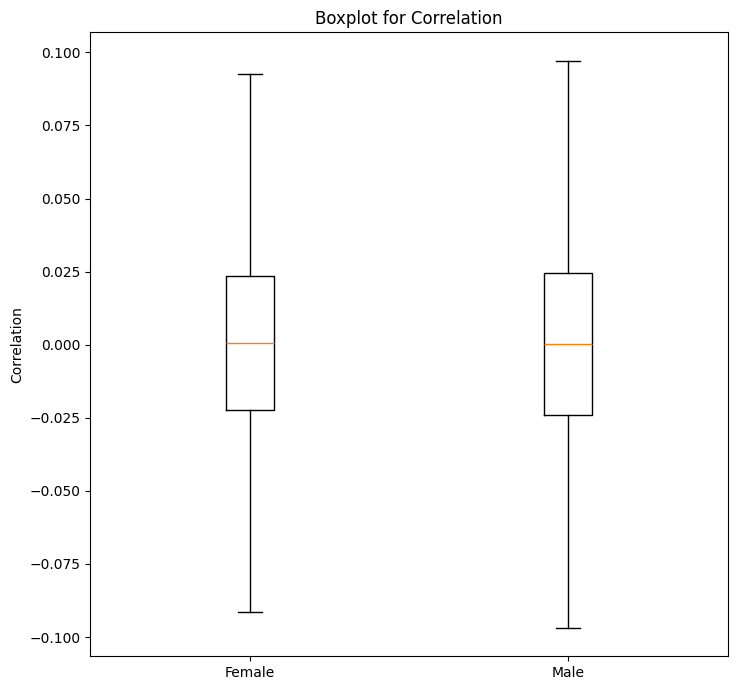

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

subject_genders = {
    1: 'F', 
    2: 'M', 
    3: 'F', 
    4: 'F', 
    5: 'F', 
    6: 'F', 
    7: 'F', 
    8: 'F', 
    9: 'M',
    10: 'F', 
    11: 'M', 
    12: 'M', 
    13: 'M', 
    14: 'M', 
    15: 'F', 
    16: 'M'
}

pc_folder = 'ACCBVP_PC' 

data_female = {'correlation': []}  
data_male = {'correlation': []}    


for subject_id in [id for id in range(first_subject_id, last_subject_id + 1) if id not in dropped_subjects]:
    csv_file = os.path.join(pc_folder, f'segmented_df_{subject_id}_PC.csv')
    
    if os.path.exists(csv_file): 
        csv_data = pd.read_csv(csv_file)
        
        correlation = csv_data['accbvp_correlation'].dropna() 
        group = subject_genders.get(subject_id, None)

        if group:
            if group == 'F':
                data_female['correlation'].extend(correlation)
            elif group == 'M':
                data_male['correlation'].extend(correlation)   

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.boxplot([data_female['correlation'], data_male['correlation']], sym='', labels=['Female', 'Male'])
plt.title("Boxplot for Correlation")
plt.ylabel('Correlation')

plt.tight_layout()
plt.show()


Pearson correlation HN/PD

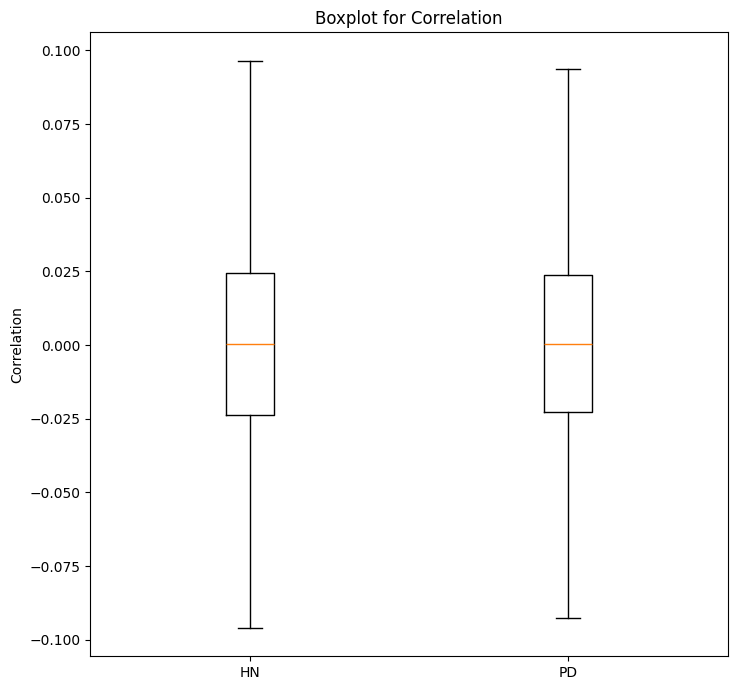

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

subject_genders = {
    1: 'HN', 2: 'HN', 3: 'PD', 4: 'PD', 5: 'PD', 6: 'PD', 7: 'HN', 8: 'HN', 9: 'PD', 
    10: 'PD', 11: 'PD', 12: 'HN', 13: 'PD', 14: 'HN', 15: 'HN', 16: 'HN'
}


pc_folder = 'ACCBVP_PC' 

data_HN = {'correlation': []}  
data_PD = {'correlation': []}    


for subject_id in [id for id in range(first_subject_id, last_subject_id + 1) if id not in dropped_subjects]:
    csv_file = os.path.join(pc_folder, f'segmented_df_{subject_id}_PC.csv')
    
    if os.path.exists(csv_file): 
        csv_data = pd.read_csv(csv_file)
        
        correlation = csv_data['accbvp_correlation'].dropna() 
        group = subject_genders.get(subject_id, None)

        if group:
            if group == 'HN':
                data_HN['correlation'].extend(correlation)
            elif group == 'PD':
                data_PD['correlation'].extend(correlation)   

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.boxplot([data_HN['correlation'], data_PD['correlation']], sym='', labels=['HN', 'PD'])
plt.title("Boxplot for Correlation")
plt.ylabel('Correlation')

plt.tight_layout()
plt.show()


graining F/M pearson correlation 

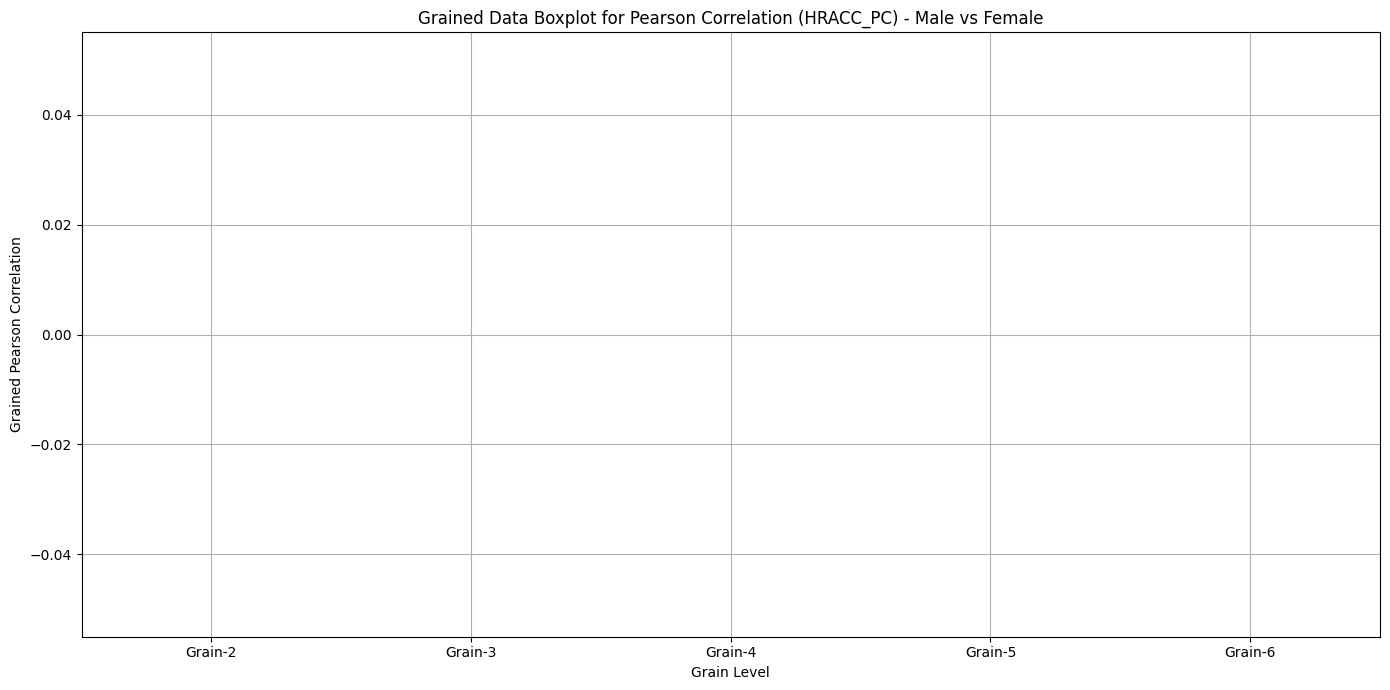

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

subject_genders = {
    1: 'F', 2: 'M', 3: 'F', 4: 'F', 5: 'F', 6: 'F', 7: 'F', 8: 'F', 9: 'M',
    10: 'F', 11: 'M', 12: 'M', 13: 'M', 14: 'M', 15: 'F', 16: 'M'
}

pc_folder = 'HR_PC/HRACC_PC'

data_female = {'HRACC_PC': []}
data_male = {'HRACC_PC': []}

for subject_id in [id for id in range(first_subject_id, last_subject_id + 1) if id not in dropped_subjects]:
    csv_file = os.path.join(pc_folder, f'segmented_df_{subject_id}_PC.csv')
    
    if os.path.exists(csv_file): 
        csv_data = pd.read_csv(csv_file)

        if '_hr_acc_correlation' in csv_data: 
            group = subject_genders.get(subject_id, None)

            if group:
                correlation = csv_data['hracc_correlation'].dropna().tolist()

                if group == 'F':
                    data_female['HRACC_PC'].extend(correlation)
                elif group == 'M':
                    data_male['HRACC_PC'].extend(correlation)

data_female_df = pd.DataFrame(data_female)
data_male_df = pd.DataFrame(data_male)

# Define graining functions
def apply_graining_2(data):
    return [sum(data[i:i+2])/2 for i in range(0, len(data)-1, 2)]  

def apply_graining_3(data):
    return [sum(data[i:i+3])/3 for i in range(0, len(data)-2, 3)]  

def apply_graining_4(data):
    return [sum(data[i:i+4])/4 for i in range(0, len(data)-3, 4)]  

def apply_graining_5(data):
    return [sum(data[i:i+5])/5 for i in range(0, len(data)-4, 5)]  

def apply_graining_6(data):
    return [sum(data[i:i+6])/6 for i in range(0, len(data)-5, 6)]  

graining_methods = {
    "Grain-2": apply_graining_2,
    "Grain-3": apply_graining_3,
    "Grain-4": apply_graining_4,
    "Grain-5": apply_graining_5,
    "Grain-6": apply_graining_6
}

data_for_df = []

for subject_id in subject_genders:
    group = subject_genders.get(subject_id, None)
    
    if group:
        # Read CSV data for each subject
        csv_file = os.path.join(pc_folder, f'segmented_df_{subject_id}_PC.csv')
        if os.path.exists(csv_file): 
            csv_data = pd.read_csv(csv_file)
            
            # Apply graining method
            if '_hr_acc_correlation' in csv_data:
                feature_data = csv_data['_hr_acc_correlation'].dropna().tolist()
                
                # Apply different graining methods
                for g_name, g_func in graining_methods.items():
                    grained_data = g_func(feature_data)
                    data_for_df.extend([(subject_id, group, g_name, val) for val in grained_data])

df = pd.DataFrame(data_for_df, columns=['SubjectID', 'Group', 'Grain', 'Value'])

# Define grain levels
grains = ["Grain-2", "Grain-3", "Grain-4", "Grain-5", "Grain-6"]

fig, axes = plt.subplots(1, 1, figsize=(14, 7))

data_to_plot_male = []
data_to_plot_female = []

for grain in grains:
    grain_data = df[df['Grain'] == grain]

    male_data = grain_data[grain_data['Group'] == 'M']['Value']
    female_data = grain_data[grain_data['Group'] == 'F']['Value']
    
    data_to_plot_male.append(male_data.tolist())  
    data_to_plot_female.append(female_data.tolist())  

positions_male = np.arange(1, len(grains)*2, 2)  
positions_female = np.arange(2, len(grains)*2+1, 2) 

# Boxplot for Male data
axes.boxplot(data_to_plot_male, positions=positions_male, labels=grains, patch_artist=True, sym="",
             boxprops=dict(facecolor='lightblue'),  # Male color
             flierprops=dict(markerfacecolor='blue', marker='o'),
             medianprops=dict(color='blue'))

# Boxplot for Female data
axes.boxplot(data_to_plot_female, positions=positions_female, labels=grains, patch_artist=True, sym="",
             boxprops=dict(facecolor='lightgreen'),  
             flierprops=dict(markerfacecolor='green', marker='o'),
             medianprops=dict(color='green'))

axes.set_title('Grained Data Boxplot for Pearson Correlation (HRACC_PC) - Male vs Female')
axes.set_ylabel('Grained Pearson Correlation')
axes.set_xlabel('Grain Level')

axes.set_xticks(np.arange(1.5, len(grains)*2+1, 2))  
axes.set_xticklabels(grains)

axes.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


graining HN/PD pearson correlation 

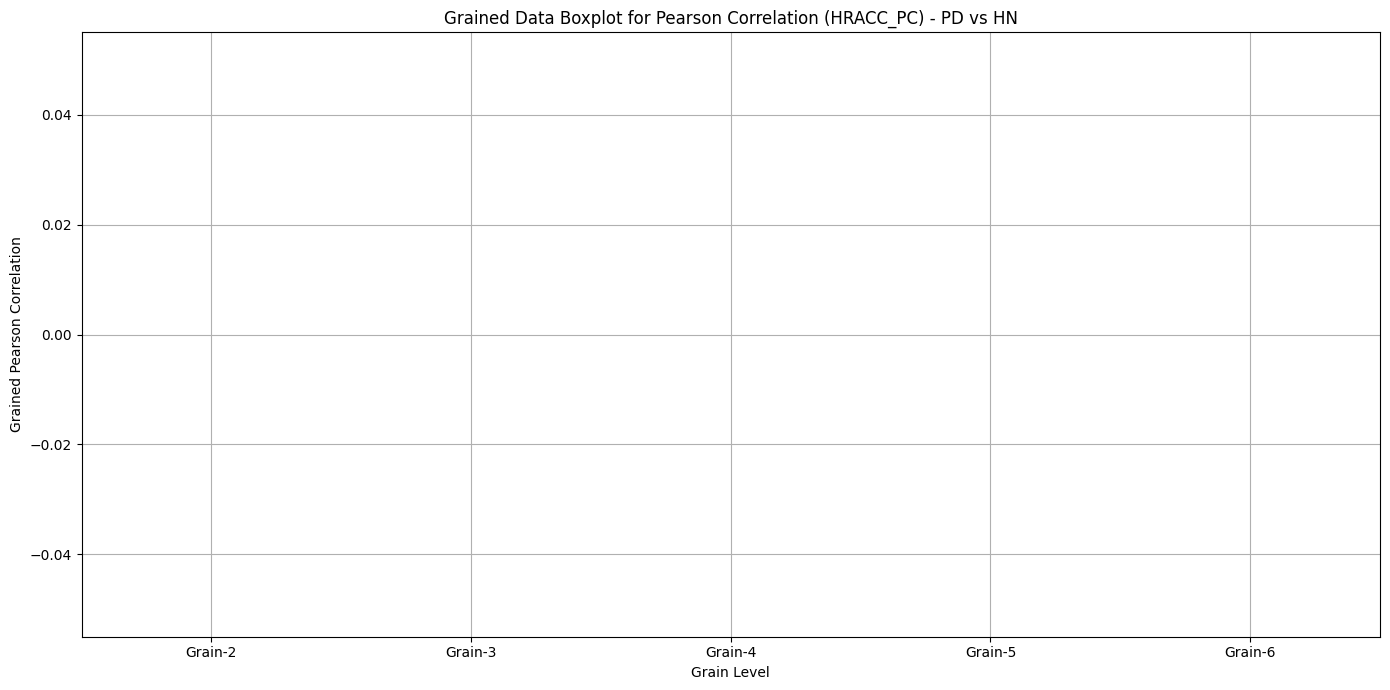

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

subject_groups = {
    1: 'HN', 
    2: 'HN', 
    3: 'PD', 
    4: 'PD', 
    5: 'PD', 
    6: 'PD', 
    7: 'HN', 
    8: 'HN', 
    9: 'PD', 
    10: 'PD', 
    11: 'PD', 
    12: 'HN', 
    13: 'PD', 
    14: 'HN', 
    15: 'HN', 
    16: 'HN'
}

pc_folder = 'HR_PC/HRACC_PC'

def apply_graining_2(data):
    return [sum(data[i:i+2])/2 for i in range(0, len(data)-1, 2)]  

def apply_graining_3(data):
    return [sum(data[i:i+3])/3 for i in range(0, len(data)-2, 3)]  

def apply_graining_4(data):
    return [sum(data[i:i+4])/4 for i in range(0, len(data)-3, 4)]  

def apply_graining_5(data):
    return [sum(data[i:i+5])/5 for i in range(0, len(data)-4, 5)]  

def apply_graining_6(data):
    return [sum(data[i:i+6])/6 for i in range(0, len(data)-5, 6)]  

graining_methods = {
    "Grain-2": apply_graining_2,
    "Grain-3": apply_graining_3,
    "Grain-4": apply_graining_4,
    "Grain-5": apply_graining_5,
    "Grain-6": apply_graining_6
}

data_for_df = []

# Iterate over all subjects
for subject_id in subject_groups:
    group = subject_groups.get(subject_id, None)
    
    if group:
        csv_file = os.path.join(pc_folder, f'segmented_df_{subject_id}_PC.csv')
        if os.path.exists(csv_file): 
            csv_data = pd.read_csv(csv_file)
            
            # Apply graining method
            if '_hr_acc_correlation' in csv_data:
                feature_data = csv_data['_hr_acc_correlation'].dropna().tolist()
                
                # Apply different graining methods
                for g_name, g_func in graining_methods.items():
                    grained_data = g_func(feature_data)
                    data_for_df.extend([(subject_id, group, g_name, val) for val in grained_data])

df = pd.DataFrame(data_for_df, columns=['SubjectID', 'Group', 'Grain', 'Value'])

# Define grain levels
grains = ["Grain-2", "Grain-3", "Grain-4", "Grain-5", "Grain-6"]

fig, axes = plt.subplots(1, 1, figsize=(14, 7))

data_to_plot_PD = []
data_to_plot_HN = []

for grain in grains:
    grain_data = df[df['Grain'] == grain]

    PD_data = grain_data[grain_data['Group'] == 'PD']['Value']
    HN_data = grain_data[grain_data['Group'] == 'HN']['Value']
    
    data_to_plot_PD.append(PD_data.tolist())  
    data_to_plot_HN.append(HN_data.tolist())  

positions_PD = np.arange(1, len(grains)*2, 2)  
positions_HN = np.arange(2, len(grains)*2+1, 2) 

axes.boxplot(data_to_plot_PD, positions=positions_PD, labels=grains, patch_artist=True, sym="",
             boxprops=dict(facecolor='lightblue'), 
             flierprops=dict(markerfacecolor='blue', marker='o'),
             medianprops=dict(color='blue'))

axes.boxplot(data_to_plot_HN, positions=positions_HN, labels=grains, patch_artist=True, sym="",
             boxprops=dict(facecolor='lightgreen'),  
             flierprops=dict(markerfacecolor='green', marker='o'),
             medianprops=dict(color='green'))

axes.set_title('Grained Data Boxplot for Pearson Correlation (HRACC_PC) - PD vs HN')
axes.set_ylabel('Grained Pearson Correlation')
axes.set_xlabel('Grain Level')

axes.set_xticks(np.arange(1.5, len(grains)*2+1, 2))  
axes.set_xticklabels(grains)

axes.grid(True)

plt.tight_layout()
plt.show()
